### Forecasting at Scale ft. Prophet 

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Prophet is open source software released by Facebook’s Core Data Science team.

Source: https://facebook.github.io/prophet/

Reference for conceptual understanding: 
1. https://research.facebook.com/blog/2017/2/prophet-forecasting-at-scale/
2. https://otexts.com/fpp3/prophet.html 

<b>Loading the required packages:</b>

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tqdm

<b>Loading the Data:</b>\
Working with the hourly power consumption data from PJM. 

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia. The hourly power consumption data comes from PJM's website and are in megawatts (MW).

In [13]:
import glob
import zipfile

files = glob.glob('*.zip')
files 

['PJME_hourly.csv.zip']

In [14]:
for file in files:
    print('Unzipping:', file)

    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('Data-Files')



Unzipping: PJME_hourly.csv.zip


Reference for parsing date-time while reading csv: 
1. https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
2. https://towardsdatascience.com/4-tricks-you-should-know-to-parse-date-columns-with-pandas-read-csv-27355bb2ad0e

In [28]:
data = pd.read_csv("Data-Files/PJME_hourly.csv", index_col = [0], parse_dates = [0])
data.shape

(145366, 1)

In [31]:
data.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<AxesSubplot: xlabel='Datetime'>

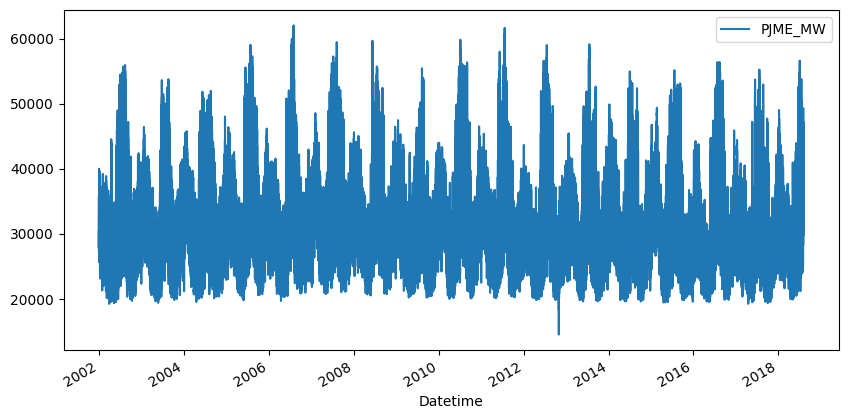

In [30]:
data.plot(figsize=(10, 5), rot = 30)

Just looking at the time series plot and trying to read it through the lens of a forecaster, we can observe a flat trend overall, there is a strong evidence for seasonality but of varying levels. One might also speculate presence of cycle in this particular time series. Overall, it looks an interesting data to analyze. 

To take a deeper look, we can start by understanding the time series pattern at various levels of time viz. week, hour, time of year, etc. 

In [33]:
def date_comp(df, label = None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour 
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year','dayofyear',
                                                    'dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    
    return X

X, y = date_comp(data, label = 'PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

In [35]:
X[:3]

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1


In [37]:
y[:3]

Datetime
2002-12-31 01:00:00    26498.0
2002-12-31 02:00:00    25147.0
2002-12-31 03:00:00    24574.0
Name: PJME_MW, dtype: float64

In [38]:
features_and_target[:3]

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0


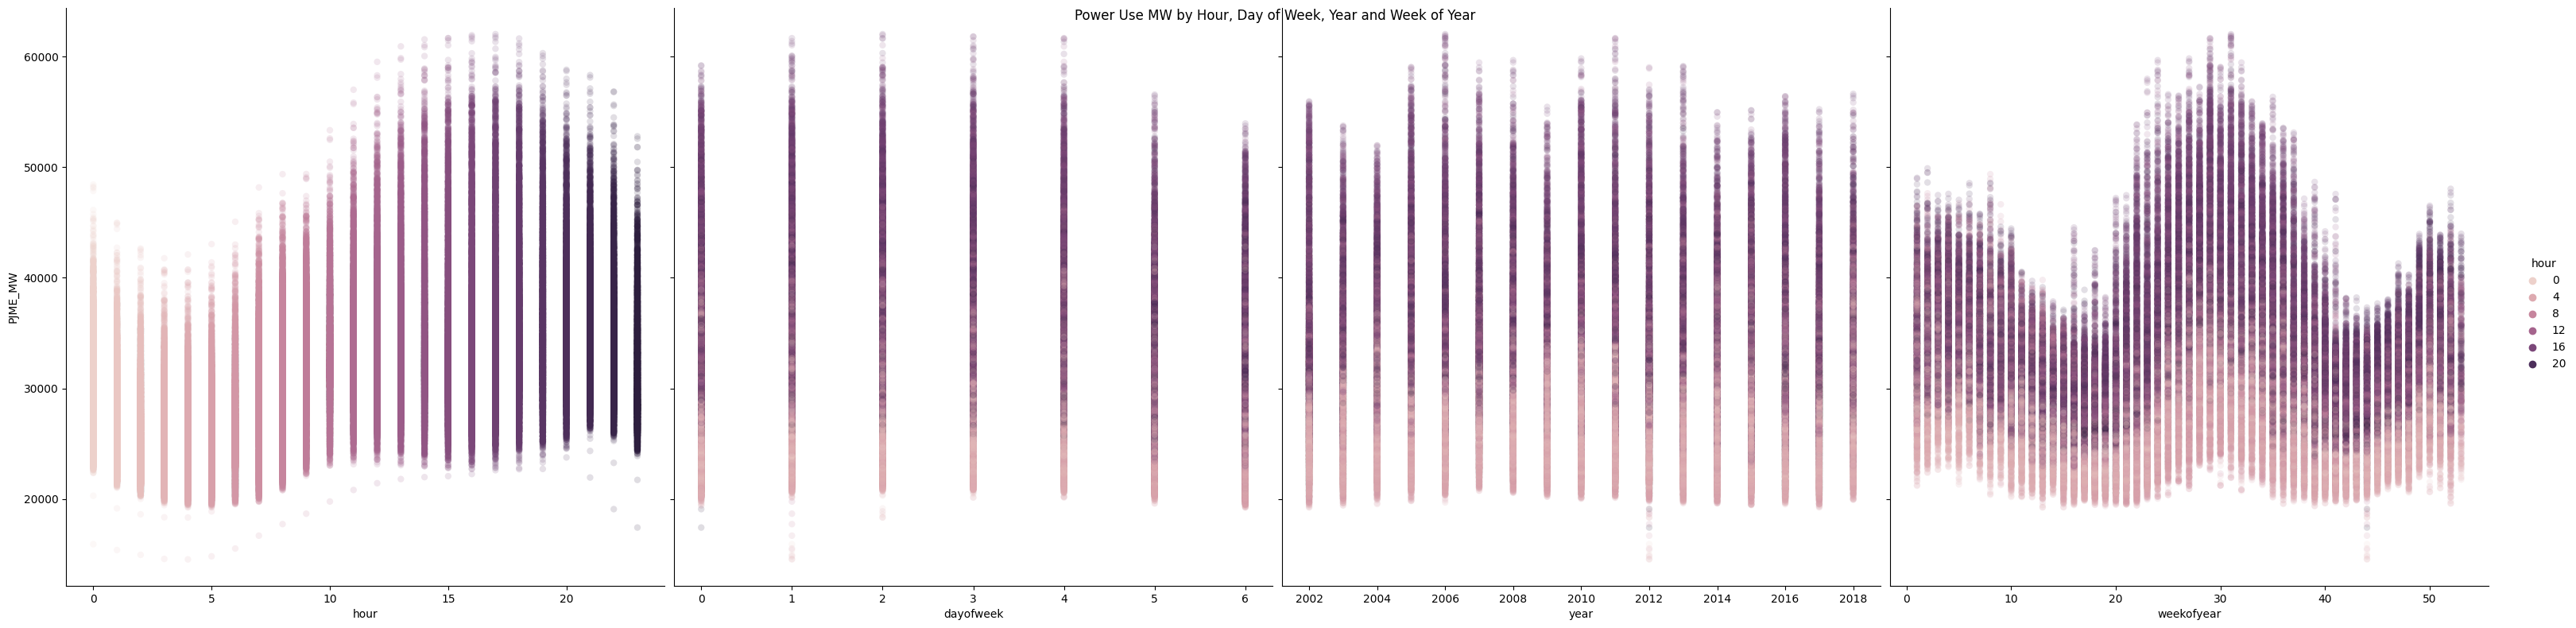

In [40]:
sns.pairplot(features_and_target.dropna(), hue='hour', 
                 x_vars=['hour','dayofweek','year','weekofyear'], y_vars='PJME_MW',
                     height=8, plot_kws={'alpha':0.15, 'linewidth':0})

plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

<b>Splitting data for training, validation, and test</b>\
Using the data after 2015 as validation set. 

In [42]:
split_date = '01-Jan-2015'
train = data.loc[data.index <= split_date].copy()
test = data.loc[data.index > split_date].copy()

In [43]:
train[:3]

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0


In [44]:
test[:3]

,PJME_MW
Datetime,
2015-12-31 01:00:00,24305.0
2015-12-31 02:00:00,23156.0
2015-12-31 03:00:00,22514.0


<AxesSubplot: title={'center': 'PJM East'}, xlabel='Datetime'>

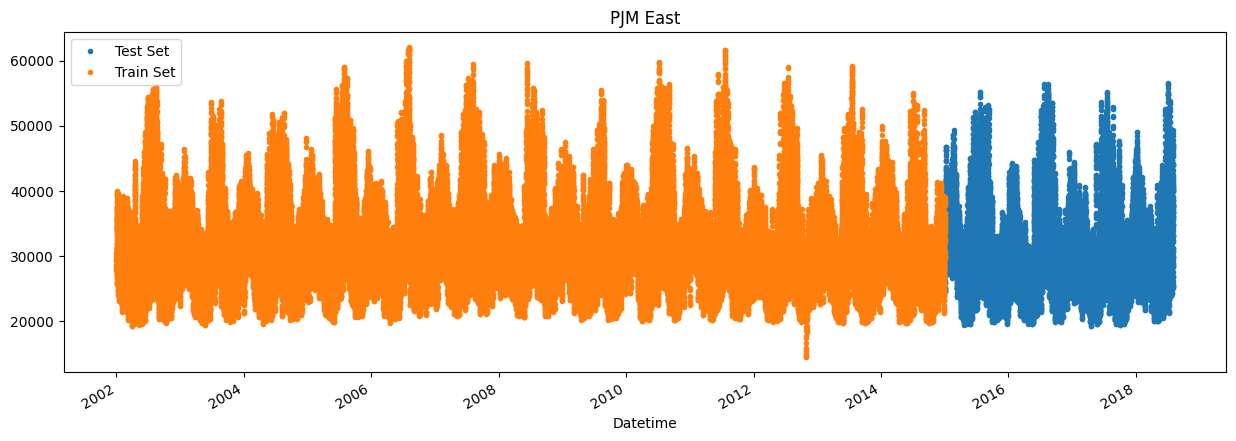

In [46]:
test.rename(columns = {'PJME_MW': 'Test Set'}) \
        .join(train.rename(columns = {'PJME_MW': 'Train Set'}), how = 'outer') \
            .plot(figsize = (15, 5), title = 'PJM East', style = '.')

<b>Using the Prophet Model:</b>\
We need to have the dataset named in a specific way so we will do preprocessing before passing it through the model. 

In [48]:
train.reset_index().rename(columns = {'Datetime': 'ds','PJME_MW': 'y'}).head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [49]:
model = Prophet()
model.fit(train.reset_index().rename(columns={'Datetime': 'ds', 'PJME_MW': 'y'}))

19:05:07 - cmdstanpy - INFO - Chain [1] start processing
19:07:07 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
forecast = model.predict(df = test.reset_index().rename(columns={'Datetime': 'ds'}))
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31210.655840,24155.073787,32885.371997,31210.655840,31210.655840,-2836.546236,-2836.546236,-2836.546236,-4430.257014,...,1281.381480,1281.381480,1281.381480,312.329298,312.329298,312.329298,0.0,0.0,0.0,28374.109604
1,2015-01-01 02:00:00,31210.618495,22378.274934,31208.586342,31210.618495,31210.618495,-4340.877318,-4340.877318,-4340.877318,-5927.136065,...,1272.622337,1272.622337,1272.622337,313.636409,313.636409,313.636409,0.0,0.0,0.0,26869.741177
2,2015-01-01 03:00:00,31210.581150,21428.147766,30231.057238,31210.581150,31210.581150,-5212.566810,-5212.566810,-5212.566810,-6790.209329,...,1262.657510,1262.657510,1262.657510,314.985010,314.985010,314.985010,0.0,0.0,0.0,25998.014341
3,2015-01-01 04:00:00,31210.543805,21215.433321,30372.748412,31210.543805,31210.543805,-5354.139173,-5354.139173,-5354.139173,-6922.124898,...,1251.610598,1251.610598,1251.610598,316.375126,316.375126,316.375126,0.0,0.0,0.0,25856.404632
4,2015-01-01 05:00:00,31210.506461,22090.228069,30805.549917,31210.506461,31210.506461,-4679.829485,-4679.829485,-4679.829485,-6237.253679,...,1239.617413,1239.617413,1239.617413,317.806782,317.806782,317.806782,0.0,0.0,0.0,26530.676976


Woah, Prophet gives the trend, and additive as well as multiplicative components for our time series. 

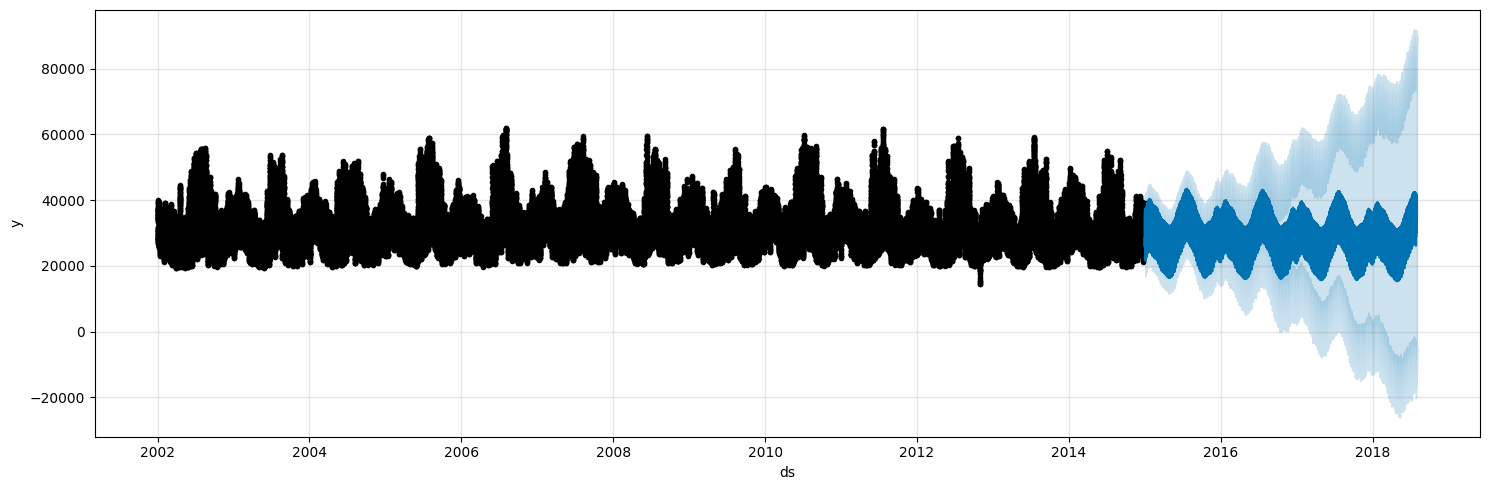

In [54]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

fig = model.plot(forecast, ax=ax)
plt.show()

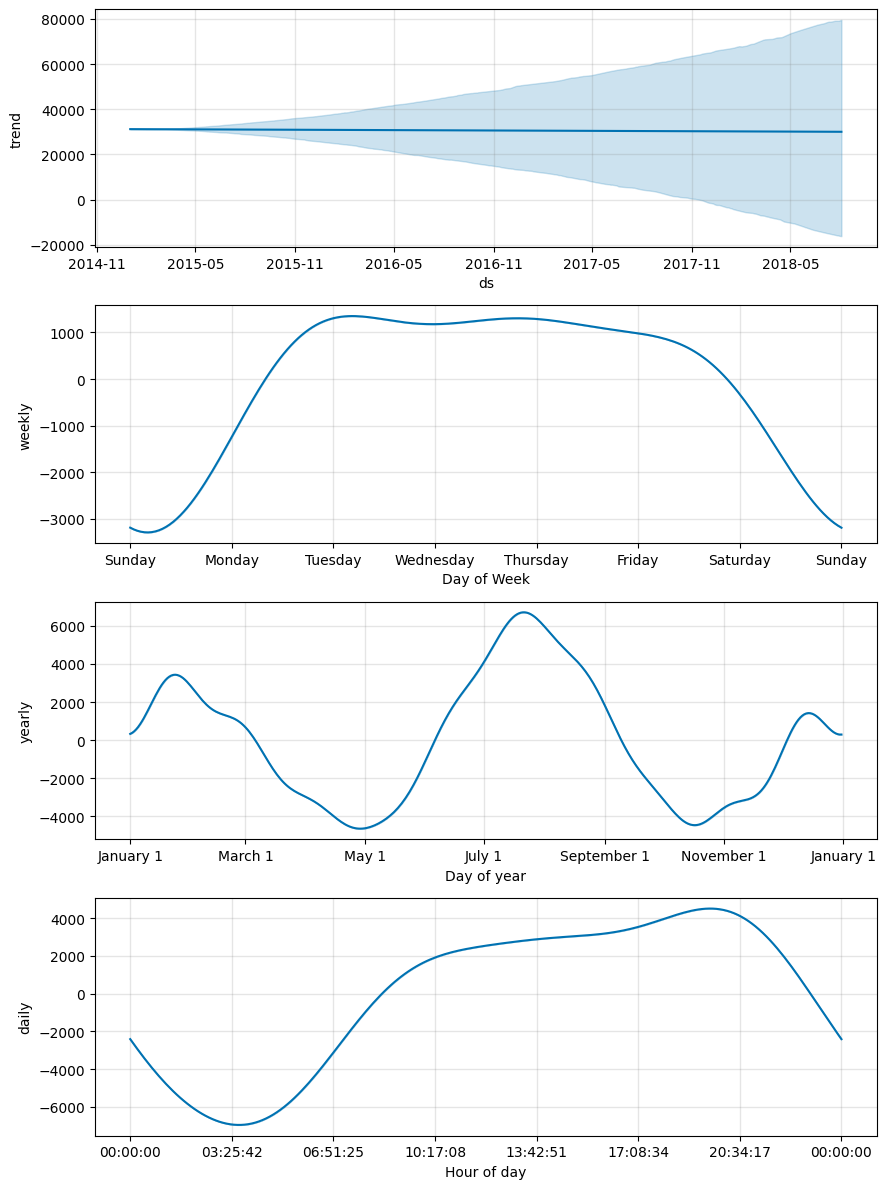

In [55]:
fig = model.plot_components(forecast)

<b>Comparing the forecast to actuals:</b>

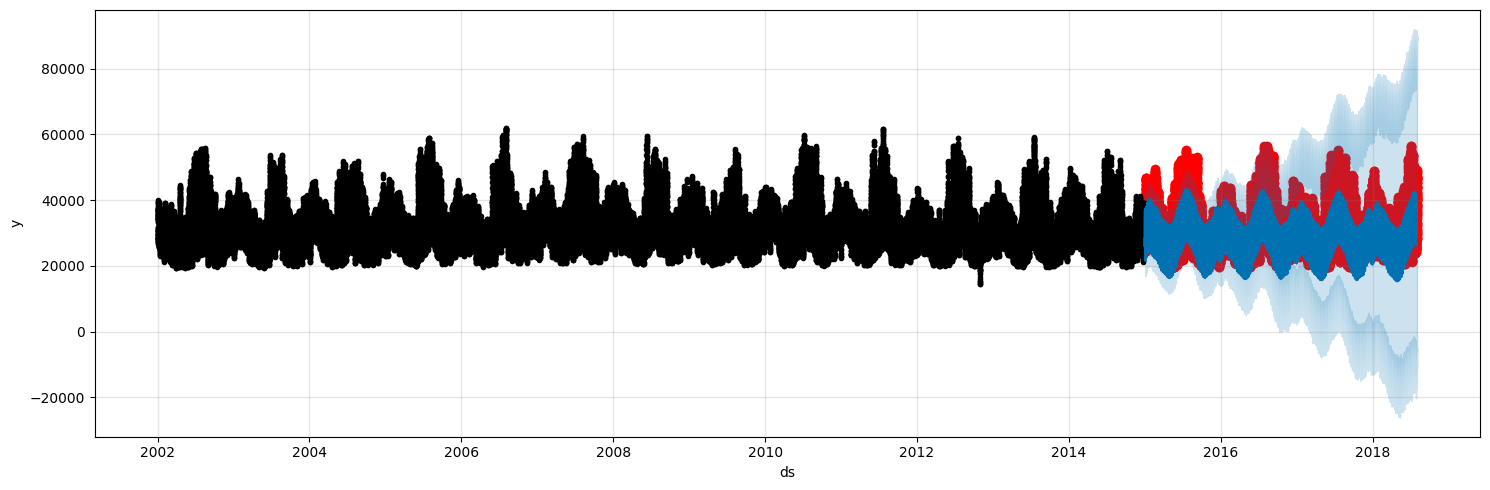

In [58]:
# Plot the forecast with the actuals

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

ax.scatter(test.index, test['PJME_MW'], color='r')
fig = model.plot(forecast, ax=ax)

<b>Error Metrics:</b>

In [124]:
mean_squared_error(y_true = test['PJME_MW'], y_pred = forecast['yhat'])

43769081.64630041

In [125]:
mean_absolute_error(y_true = test['PJME_MW'], y_pred = forecast['yhat'])

5182.108151350848

In [130]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true = test['PJME_MW'], y_pred = forecast['yhat'])

16.50930958243868

<b>Holiday Effects from Prophet</b>:\
Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training. We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays.  

In [126]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()

train_holidays = cal.holidays(start=train.index.min(), end=train.index.max())
test_holidays = cal.holidays(start=test.index.min(), end=test.index.max())

In [127]:
data['date'] = data.index.date
data['is_holiday'] = data.date.isin([d.date() for d in cal.holidays()])

holiday_df = data.loc[data['is_holiday']].reset_index().rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2003-01-01 00:00:00,USFederalHoliday
1,2002-12-25 01:00:00,USFederalHoliday
2,2002-12-25 02:00:00,USFederalHoliday
3,2002-12-25 03:00:00,USFederalHoliday
4,2002-12-25 04:00:00,USFederalHoliday


In [128]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [129]:
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(train.reset_index().rename(columns={'Datetime':'ds',
                                                                     'PJME_MW':'y'}))

19:55:35 - cmdstanpy - INFO - Chain [1] start processing
19:57:17 - cmdstanpy - INFO - Chain [1] done processing


In [131]:
forecast_holiday = model_with_holidays.predict(df=test.reset_index().rename(columns={'Datetime':'ds'}))

In [134]:
mean_squared_error(y_true = test['PJME_MW'], y_pred = forecast_holiday['yhat'])

43890730.4152759

In [135]:
mean_absolute_error(y_true = test['PJME_MW'], y_pred = forecast_holiday['yhat'])

5190.7642010064665

In [133]:
mean_absolute_percentage_error(y_true = test['PJME_MW'], 
                                           y_pred = forecast_holiday['yhat'])

16.539989698610665

Oops, errors increased after considering holiday effects! But there is a possibility that this model will perform good for the specific holiday dates e.g. 4th of July. 

In [137]:
jul4_test = test.query('Datetime >= 20160407 and Datetime < 20160408')
jul4_pred = forecast.query('ds >= 20160407 and ds < 20160408')
jul4_pred_holiday = forecast_holiday.query('ds >= 20160407 and ds < 20160408')

In [138]:
mean_absolute_error(y_true=jul4_test['PJME_MW'], y_pred=jul4_pred['yhat'])

2159.521361577958

In [141]:
mean_absolute_error(y_true=jul4_test['PJME_MW'], y_pred=jul4_pred_holiday['yhat'])

2157.59363735205

Not a very significant difference. 

Let's go back to the exploratory mode and see if there are any sharp outliers in the data, dealing with which could help improve the model performance. But these outlier values by themselves can be a signal or indicative of some real world rare event. 

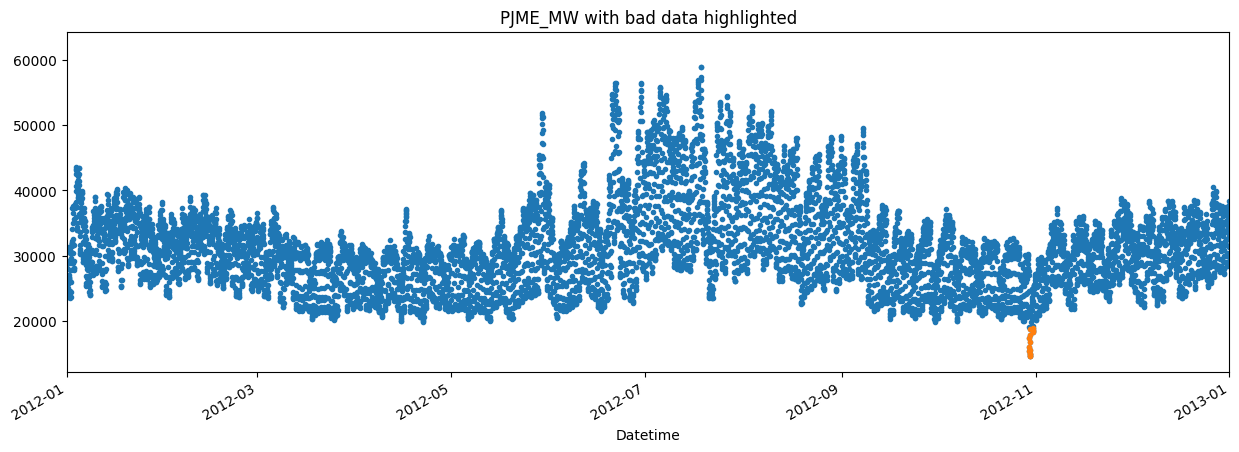

In [144]:
ax = train.plot(style='.',
                     figsize=(15,5),
                     title='PJME_MW with bad data highlighted',
                     xlim=('01-01-2012','01-01-2013')
                    )
train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()



<AxesSubplot: xlabel='Datetime'>

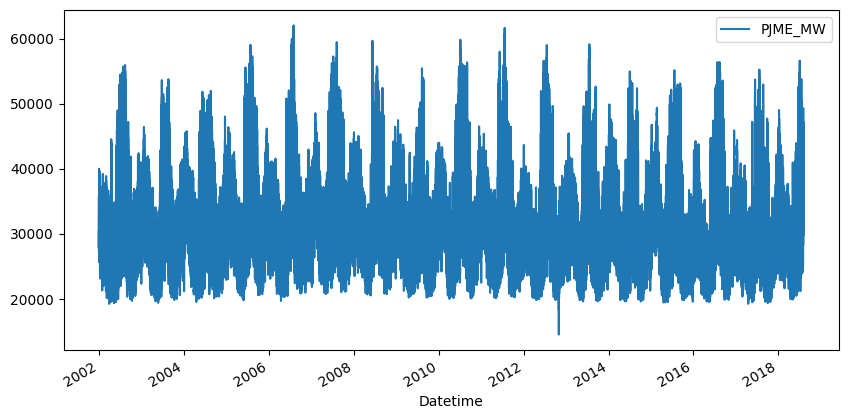

In [145]:
data.plot(figsize=(10, 5), rot = 30)

If we look at the basic time series plot, we can observe a sharp dip in 2013 which is rare anywhere else. (Hint: Hurricane Sandy)

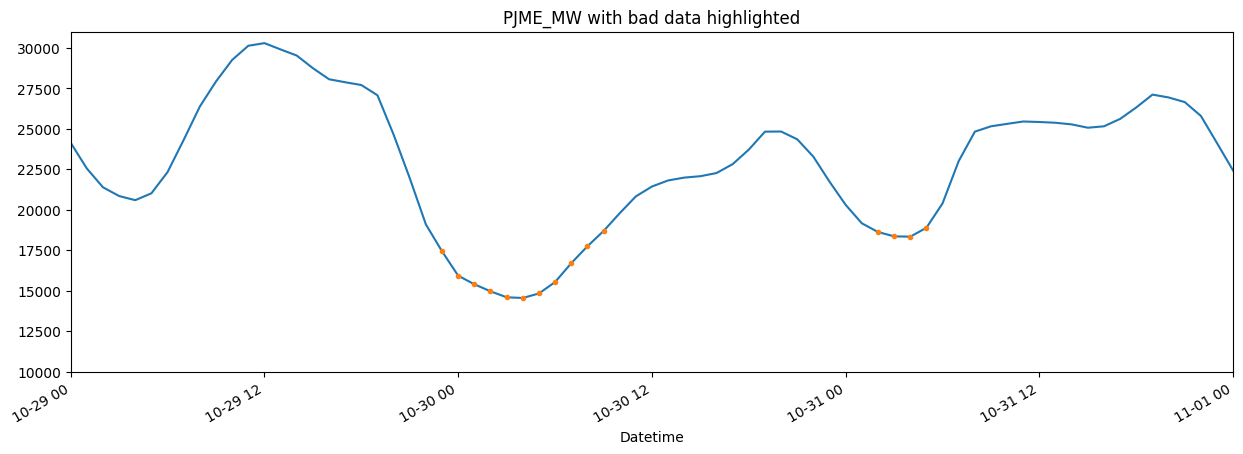

In [153]:
ax = train.plot(figsize=(15,5), title='PJME_MW with bad data highlighted',
                     xlim=('10-29-2012','11-01-2012'), ylim=(10000, 31000)
                    )
train.query('PJME_MW < 19000').plot(style='.', figsize=(15,5),ax=ax)
ax.legend().set_visible(False)
plt.show()

<b>References:</b>
1. https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet
2. https://www.kaggle.com/code/chandlerlane/hourly-energy-consumption
3. https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
4. https://peerj.com/preprints/3190/